### `pix2pix` night2day.

In this notebook we are going to continue with `cGAN's` models. 

In this model we are going to do the same on the night2day dataset which is found [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)

### Imports

In [1]:
import tensorflow as tf
import time, os
from prettytable import PrettyTable
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

np.__version__

'1.19.5'

### Dataset.

In [2]:
base_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/"
dataset_folder = "night2day.tar.gz"

path_to_zip = keras.utils.get_file(
    dataset_folder,
    origin = base_url+dataset_folder,
    extract=True
)
PATH = os.path.join(os.path.dirname(path_to_zip), 'night2day')

2063695872/2063695642 [==============================] - 768s 0us/step


### Checking folders.

In [3]:
os.listdir(PATH)

['val', 'test', 'train']

>  This time around we have 3 sets of data the `train`, `test` and `val``

In [4]:
os.listdir(os.path.join(PATH, 'train'))

['58_4991_to_4970.jpg',
 '83_6946_to_6902.jpg',
 '90_7589_to_7594.jpg',
 '25_2113_to_2101.jpg',
 '25_2094_to_2117.jpg',
 '88_7356_to_7378.jpg',
 '36_3189_to_3174.jpg',
 '65_5533_to_5570.jpg',
 '55_4726_to_4724.jpg',
 '101_8502_to_8533.jpg',
 '9_729_to_700.jpg',
 '101_8517_to_8512.jpg',
 '69_5973_to_5881.jpg',
 '49_4219_to_4240.jpg',
 '18_1556_to_1478.jpg',
 '101_8511_to_8493.jpg',
 '36_3188_to_3168.jpg',
 '52_4446_to_4491.jpg',
 '85_7097_to_7098.jpg',
 '62_5286_to_5305.jpg',
 '101_8566_to_8528.jpg',
 '2_142_to_208.jpg',
 '25_2104_to_2096.jpg',
 '49_4248_to_4234.jpg',
 '4_374_to_314.jpg',
 '9_715_to_738.jpg',
 '20_1644_to_1657.jpg',
 '54_4669_to_4640.jpg',
 '52_4446_to_4468.jpg',
 '67_5764_to_5662.jpg',
 '38_3311_to_3375.jpg',
 '96_8082_to_8081.jpg',
 '36_3193_to_3172.jpg',
 '12_982_to_944.jpg',
 '88_7352_to_7382.jpg',
 '88_7376_to_7342.jpg',
 '20_1681_to_1720.jpg',
 '54_4644_to_4667.jpg',
 '34_2990_to_3030.jpg',
 '33_2936_to_2920.jpg',
 '52_4445_to_4490.jpg',
 '42_3670_to_3699.jpg',
 '

In [5]:
sample_image = tf.io.read_file(os.path.join(
    PATH, 'train/58_4991_to_4970.jpg'
))
sample_image = tf.io.decode_jpeg(sample_image)
sample_image.shape

TensorShape([256, 512, 3])

> Again the shape is still the same as from the previous. Meaning we have two images that are joined together. We will need to serparate them using helper functions but first let visualize our `sample_image`

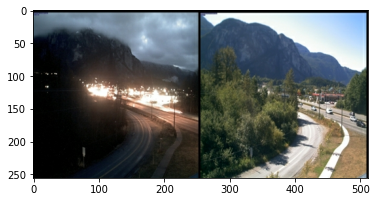

In [6]:
plt.imshow(sample_image)
plt.show()

We are going to split these images into two of size `256 x 256`. Let's define our helper function that will load the image and split.

In [7]:
def load_splited_images(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image)
  width = 256
  real_image = image[:, width:, :]
  input_image = image[:, :width, :]
  return tf.cast(input_image, tf.float32), tf.cast(real_image, tf.float32)



### Plotting the splited image.
We are now going to plot the two images so that we see what we have.

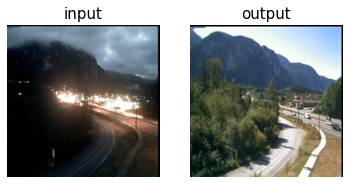

In [8]:
def plot_image_pairs(images, labels, cols=2, rows=1):
  fig = plt.figure()
  fig.set_size_inches(cols*3, rows *3)
  for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(rows, cols, i +1)
    plt.axis('off')
    plt.imshow(image, cmap="gray")
    plt.title(label, color='k', fontsize=15)

inp, out = load_splited_images(os.path.join(PATH, 'train/58_4991_to_4970.jpg'))
plot_image_pairs([inp/255.0, out/255.0], labels=["input", "output"])



### Creating a `pix2pix` model.

We are going to define a function that:

1. Resize each `256 x 256` to `286 x 286`.
2. Randomly crop it back to `256 x 256`
3. Random flip the image horizontally that is left to right (random mirroring).
4. We then normalize the images `[-1, 1]` range.

### Hyper params

In [9]:
IMG_WIDTH = IMG_HEIGHT = 256
BATCH_SIZE ,BUFFER_SIZE = 1, 400

In [10]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, (height, width),
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
                                )
  real_image = tf.image.resize(real_image, (height, width),
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
                               )
  return input_image, real_image

### Random image cropping.

In [11]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([
                            input_image, real_image
                  ], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size = [2, IMG_HEIGHT, IMG_WIDTH, 3]
  )
  return cropped_image[0], cropped_image[1]

### Normalizing images.

In [12]:
def normalize(input_image, real_image):
  input_image = (input_image/127.5) -1
  real_image = (real_image/127.5) -1
  return input_image, real_image

### Random `jittering`.

In [13]:
@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > .5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

### Display processed images.

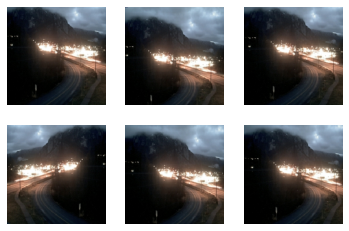

In [15]:
for i in range(6):
  rj_inp, rj_re = random_jitter(inp, out)
  plt.subplot(2, 3, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

### Helper functions.
Now we will create two helper function that will process 3 different sets. The `train`, `test` and the `val` set.

**Note: ** The training and the validation set must only be resized and normalized, therefore their trasformation are the same.

In [16]:
def load_image_train(file_name):
  input_image, real_image = load_splited_images(file_name)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

def load_image_test(file_name):
  input_image, real_image = load_splited_images(file_name)
  input_image, real_image = resize(
      input_image, real_image, IMG_HEIGHT, IMG_WIDTH
  )
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image
  
def load_image_valid(file_name):
  input_image, real_image = load_splited_images(file_name)
  input_image, real_image = resize(
      input_image, real_image, IMG_HEIGHT, IMG_WIDTH
  )
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

### Building the input pipeline using the `tf.data`.


In [17]:
train_ds = tf.data.Dataset.list_files(PATH + '/train/*.jpg')
train_ds = train_ds.map(load_image_train,
                        num_parallel_calls = tf.data.AUTOTUNE
                        ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

valid_ds = tf.data.Dataset.list_files(PATH + '/val/*.jpg')
valid_ds = valid_ds.map(load_image_valid).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.list_files(PATH + '/test/*.jpg')
test_ds = test_ds.map(load_image_test).batch(BATCH_SIZE)

### Checking how many examples do we have for each set.

In [ ]:
colums_data = "SUBSET", "EXAMPLE(s)"
rows_data = [
             ["training", f'{len(train_ds):,}'], 
             ["validation", f'{len(valid_ds):,}'],
             ["testing", f'{len(test_ds):,}']
  ]
title = "TOTAL EXAMPLES FOR ALL SUBSETS"
def tabulate_example(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)
tabulate_example(colums_data, rows_data, title)

Again we are going to use `1.k` images for training and so that the training won't take long. but for better results i encorange training on a larger sample.

In [18]:
train_ds = train_ds.take(1000)

In [19]:
colums_data = "SUBSET", "EXAMPLE(s)"
rows_data = [
             ["training", f'{len(train_ds):,}'], 
             ["validation", f'{len(valid_ds):,}'],
             ["testing", f'{len(test_ds):,}']
  ]
title = "TOTAL EXAMPLES FOR ALL SUBSETS"
def tabulate_example(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)
tabulate_example(colums_data, rows_data, title)

+---------------------------------+
|  TOTAL EXAMPLES FOR ALL SUBSETS |
+----------------+----------------+
| SUBSET         |     EXAMPLE(s) |
+----------------+----------------+
| training       |          1,000 |
| validation     |             10 |
| testing        |          2,287 |
+----------------+----------------+


### The `Generator` Model.

This model consist of a decoder(downsampler) and an encoder (upsampler) which are connected to each other.

Each block is:
```
[ Convolution ] -> [Batch Normalization] -> [Leaky ReLU]
```

### Decoder.
Each block is:

```
[ Convolution ] -> [ Batch Normalization] -> [ Dropout] -> [ ReLU]
```

The `dropout` in the decoder is applied to the first three blocks. 

* There are skip connections between the encoder and decoder (as in U-Net).


### Encoder model, (Downsampler)

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
class Encoder(keras.layers.Layer):
  def __init__(self, in_features, kernel_size, apply_bn=True):
    super(Encoder, self).__init__()
    initializer = tf.random_normal_initializer(0., 0.02)

    self.apply_bn = apply_bn
    self.conv = keras.layers.Conv2D(
        in_features, kernel_size=kernel_size,
        strides=2, padding="same", use_bias=False,
        kernel_initializer=initializer
    )
    self.bn = keras.layers.BatchNormalization(momentum=.8)
    self.l_relu = keras.layers.LeakyReLU()

  def call(self, x):
    x = self.conv(x)
    if self.apply_bn:
      x = self.bn(x)
    return self.l_relu(x)

In [22]:
down_model = Encoder(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


### Decoder model, Upsampler.
From the previous notebooks we have been using the `Conv2DTranspose()` to upsample the images from a lower resolution to the upper. As I said from the previous notebook, this time around we are going to use the `Upsampling2D()` to upsample the images. During upsampling each block will look as follows:

```
[UpSampling2D] -> [Conv2D] -> [BatchNormalization] -> [Dropout?] -> [ReLU]
```



In [23]:
class Decoder(keras.layers.Layer):
  def __init__(self, in_features, kernel_size,
               apply_dropout=False):
    super(Decoder, self).__init__()
    initializer = tf.random_normal_initializer(0., .02)

    self.apply_dropout = apply_dropout
    self.conv = keras.layers.Conv2D(
        in_features, kernel_size=kernel_size,
        strides=1, padding="same",
        kernel_initializer=initializer
    )
    self.up_sampling_2d = keras.layers.UpSampling2D()
    self.bn = keras.layers.BatchNormalization(momentum=.8)
    self.dropout = keras.layers.Dropout(.5)
    self.relu = keras.layers.ReLU()

  def call(self, x):
    x = self.up_sampling_2d(x)
    x = self.conv(x)
    x = self.bn(x)
    if self.apply_dropout:
      x = self.dropout(x)
    return self.relu(x)


In [24]:
up_model = Decoder(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


### The generator model stucture.

````
        [-----------------]
          [-------------]
             [--------]
               [----]
                [--]
               [----]
             [--------]
            [-------------]
          [-----------------]
````

* First we have to ``downsample`` the image to a lower resolution using the encoder model.
* We will ``upsample`` the image using the decoder model to get back the image with the original shape.

In [25]:

def generator():
  inputs = keras.layers.Input(shape=[256, 256, 3])

  down_stack = np.array([
     Encoder(64, 3, apply_bn=False),
     Encoder(128, 3),
     Encoder(256, 3),
     Encoder(512, 3),
     Encoder(512, 3),
     Encoder(512, 3),
     Encoder(512, 3),
     Encoder(512, 3)
  ])

  up_stack = np.array([
      Decoder(512, 3, apply_dropout=True), 
      Decoder(512, 3, apply_dropout=True),  
      Decoder(512, 3, apply_dropout=True),  
      Decoder(512, 3), 
      Decoder(256, 3), 
      Decoder(128, 3),  
      Decoder(64, 3),
  ])

  initializer = tf.random_normal_initializer(0., 0.02)

  """
  REPLACING THE Conv2DTranspose WITH UpSampling2D() + Conv2D
  """

  upsampler = keras.layers.UpSampling2D(name="upsampler")
  output_layer = keras.layers.Conv2D(
      OUTPUT_CHANNELS,
      3, strides=1,
      padding= 'same',
      kernel_initializer = initializer,
      activation = 'tanh',
      name="conv_2d"
  )

  x = inputs
  skips = []

  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  for i, (up, skip) in enumerate(zip(up_stack, skips)):
    x = up(x)
    x = keras.layers.Concatenate(name=f"concatenate_layer_{i}")([x, skip])

  x = upsampler(x)
  x = output_layer(x)
  return keras.Model(inputs=inputs, outputs=x,
                     name="generator_model")

generator().summary() 

Model: "generator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder_1 (Encoder)             (None, 128, 128, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
encoder_2 (Encoder)             (None, 64, 64, 128)  74240       encoder_1[0][0]                  
__________________________________________________________________________________________________
encoder_3 (Encoder)             (None, 32, 32, 256)  295936      encoder_2[0][0]                  
____________________________________________________________________________________

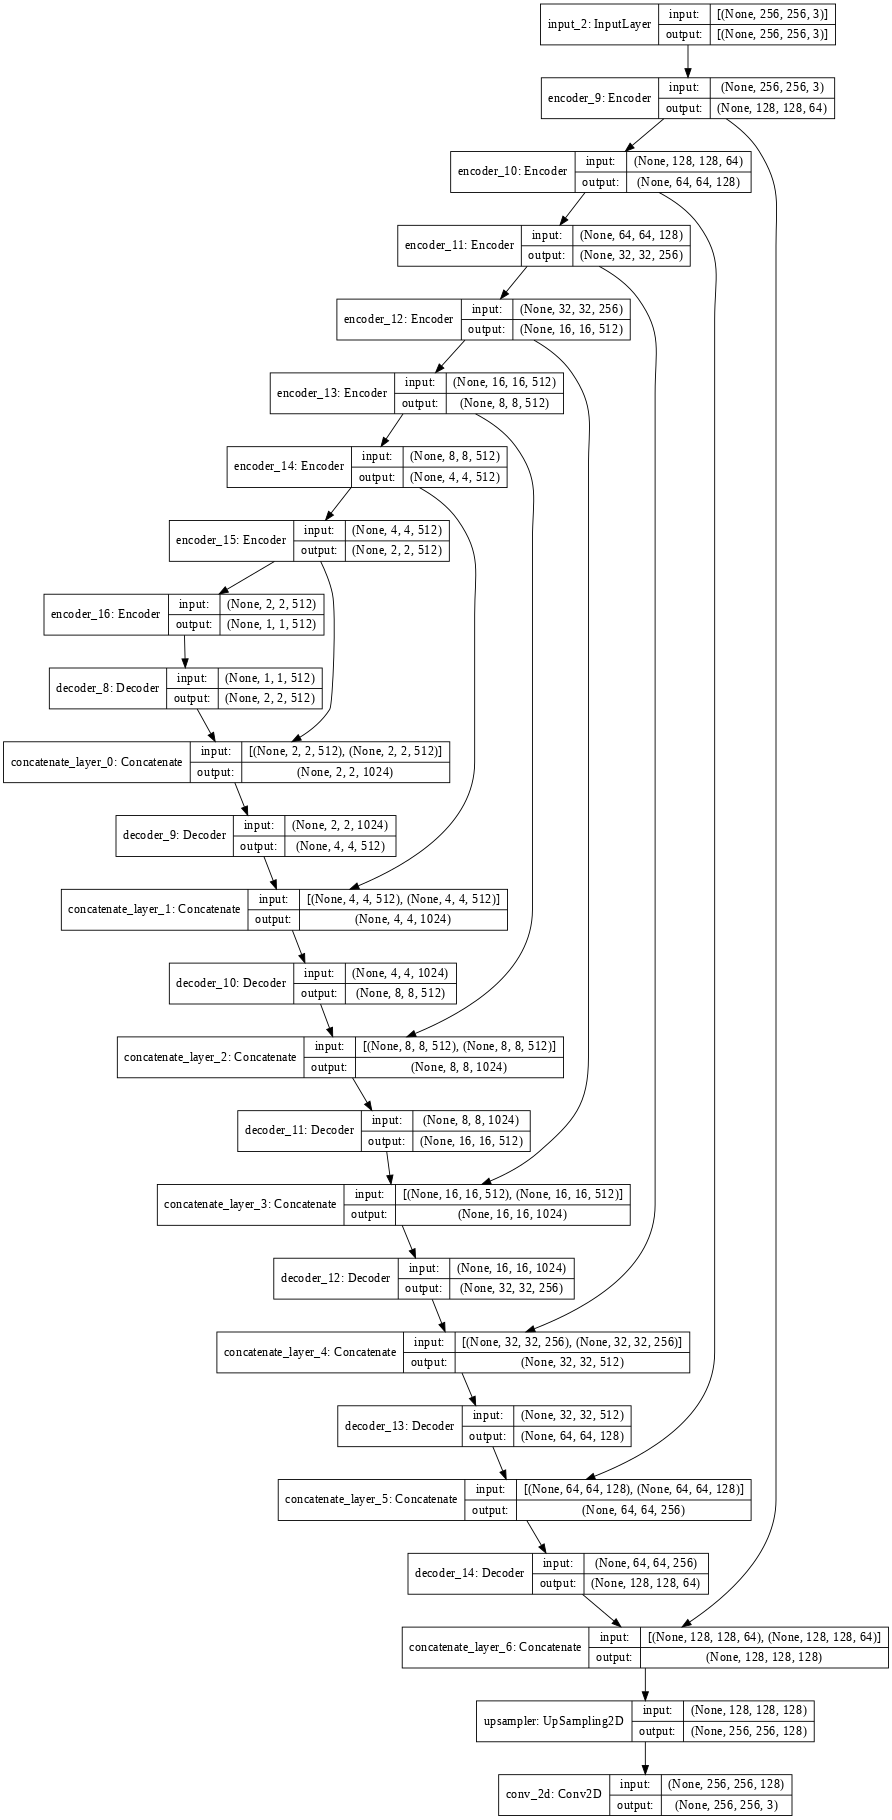

In [26]:
generator_model = generator()
keras.utils.plot_model(generator_model, dpi=64, show_shapes=True)

### Testing the generator model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


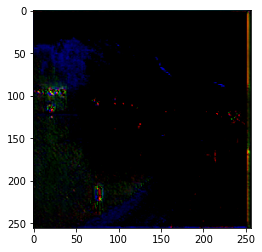

In [27]:
gen_output = generator_model(inp[tf.newaxis, ...], training=False)
print(gen_output.shape)
plt.imshow(gen_output[0, :, :, :], cmap="gray")
plt.show()

### The Discriminator model.
This model will just classify if the image is real or fake.

Each block of the descriminator looks as follows:

```
[ Convolution ] -> [Batch normalization] -> [ Leaky ReLU ]
```

- The shape of the output after the last layer is `(batch_size, 32, 32, 1)`.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

In [28]:
def discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  inp = keras.layers.Input(shape=[256, 256, 3], name="input_image")
  tar = keras.layers.Input(shape=(256, 256, 3), name="target_image")

  x = keras.layers.concatenate([inp, tar], name="concatenated_inputs") # (batch_size, 256, 256, channels*2)
  down_1 = Encoder(64, 3, False)(x) # (batch_size, 128, 128, 63)
  down_2 = Encoder(128, 3)(down_1)  # (batch_size, 64, 64, 128)
  down_3 = Encoder(256, 3)(down_2) # (batch_size, 32, 32, 256)

  zero_pad1 = keras.layers.ZeroPadding2D(name="zero_padding_layer_1")(down_3) # (batch_size, 34, 34, 256)
  
  conv = keras.layers.Conv2D(512, 3, strides=1, kernel_initializer=initializer,
                             use_bias=False,
                             name="conv_layer")(zero_pad1)
  bn_1 =  keras.layers.BatchNormalization(momentum=.8, name="bn_1")(conv)
  leaky_relu = keras.layers.LeakyReLU(name="leaky_relu")(bn_1)
  zero_pad2 = keras.layers.ZeroPadding2D(name="zero_padding_layer_2")(leaky_relu) # (batch_size, 33, 33, 512)
  last = keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer,
                             name="output_layer"
                             )(zero_pad2)  # (batch_size, 32, 32, 1)

  return keras.Model(inputs=[inp, tar], outputs=last, name="discriminator_model")
discriminator().summary()

Model: "discriminator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenated_inputs (Concatenat (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
encoder_17 (Encoder)            (None, 128, 128, 64) 3456        concatenated_in

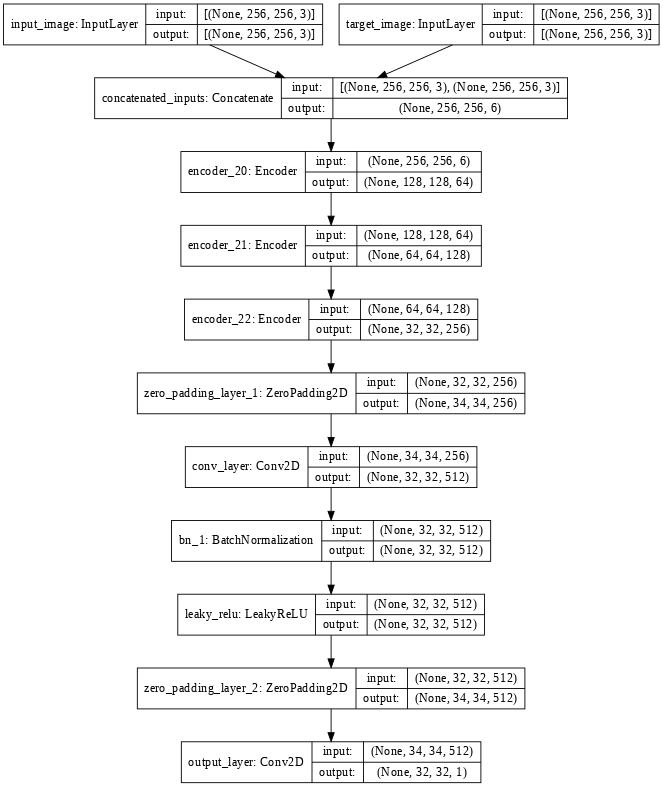

In [29]:
discriminator_model = discriminator()
keras.utils.plot_model(discriminator_model, show_shapes=True, dpi=64)

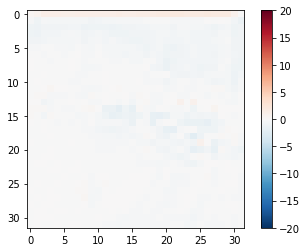

In [30]:
disc_out = discriminator_model([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.show()

### Loses.

Again we are going to have 2 different loses for the generator and the discriminator.

In [31]:
criterion = keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

In [32]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = criterion(tf.ones_like(
      disc_generated_output
  ), disc_generated_output)
  ### MAE
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = criterion(
      tf.ones_like(disc_real_output), disc_real_output
  )
  generated_loss = criterion(tf.zeros_like(disc_generated_output), disc_generated_output)

  return real_loss + generated_loss

### Optimizers.
The generator and the discriminator have the same optimizer. Which is ``Adam`` with ``learning rate = 2e-4 `` and ``beta_1= .5``

In [33]:
generator_optimizer = discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoint-saver

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

### Ploting images during training.

In [35]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(10, 10))
  images = [test_input[0], tar[0], prediction[0]]
  titles = ['input', 'real', 'generated image']
  for i, (title, image) in enumerate(zip(titles, images)):
    plt.subplot(1, 3, i+1)
    plt.title(title, fontsize=14, color="k" if i<2 else "g")
    """
    Getting the pixel values in the [0, 1] range to plot.
    """
    plt.imshow(image * .5 + .5)
    plt.axis('off')
  plt.show()

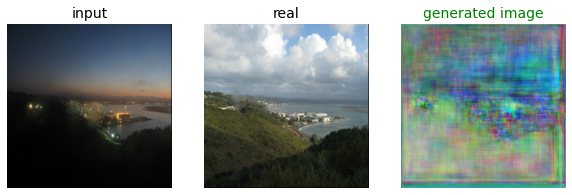

In [36]:
for example_input, example_target in valid_ds.take(1):
  generate_images(generator_model, example_input, example_target)

### Training
First we will define our train function.

In [37]:
EPOCHS = 100

In [38]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator_model(input_image, training=True)
    disc_real_output = discriminator_model([input_image, target], training=True)
    disc_generated_output = discriminator_model([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
        disc_generated_output,
        gen_output, target
    )
    disc_loss = discriminator_loss(
        disc_real_output, disc_generated_output
    )
  
  gradients_of_generator = gen_tape.gradient(
      gen_total_loss, generator_model.trainable_variables
  )
  gradients_of_dicriminator = disc_tape.gradient(
      disc_loss, discriminator_model.trainable_variables
  )

  generator_optimizer.apply_gradients(
      zip(
          gradients_of_generator, 
          generator_model.trainable_variables
      )
  )
  discriminator_optimizer.apply_gradients(
      zip(
         gradients_of_dicriminator,
          discriminator_model.trainable_variables
      )
  )
  return gen_total_loss, disc_loss



### Training loop.
In the training loop we:
- Iterates over the number of epochs.
- At each epoch: clears the display and runs `generate_images` to show the progress.
- At each epoch: iterates over the training datasetexample.
- Every 20 epochs: saves a checkpoint.


### Helper functions

1. time to string.

In [39]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

2. tabulate training epoch

In [40]:
def tabulate_training_epochs(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  table.align[column_names[2]] = 'r'
  table.align[column_names[3]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

### Training loop.

In [41]:
def fit(train_ds, epochs, valid_ds):
  columns_data =["EPOCH", "ETA", "GEN_LOSS", "DISC_LOSS"]
  for epoch in range(epochs):
    start = time.time()
    num = 0
    for n, (input_image, target) in train_ds.enumerate():
       num +=1
       gen_loss, disc_loss = train_step(input_image, target, epoch)
    if (epoch + 1) % 20 == 0:
       checkpoint.save(file_prefix=checkpoint_prefix)
    end = time.time()  

    rows_data = [
       [epoch+1, hms_string(end - start),f'{(gen_loss/num):.3f}', f'{(disc_loss/num):.3f}'],      
    ]
    title = f'EPOCH:  {epoch+1:02}/{epochs} {"display" if epoch == 0 or (epoch+1)%20 == 0 else "no display"}'
    tabulate_training_epochs(columns_data, rows_data, title)
    if epoch == 0 or (epoch+1)%20 == 0 or epoch+1 == epochs:
      for example_input, example_target in valid_ds.take(3):
        generate_images(generator_model, example_input, example_target)


### Running the training loop.

+-------------------------------------------+
|           EPOCH:  01/100 display          |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 1     | 0:01:02.23 |    0.027 |     0.001 |
+-------+------------+----------+-----------+


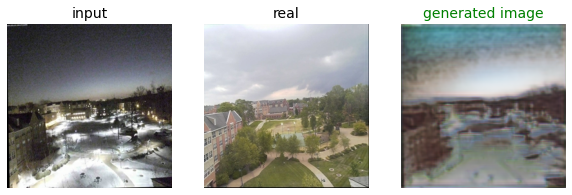

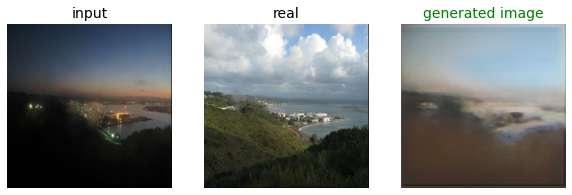

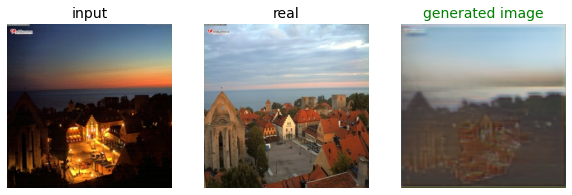

+-------------------------------------------+
|         EPOCH:  02/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 2     | 0:00:59.39 |    0.025 |     0.001 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  03/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 3     | 0:01:00.06 |    0.031 |     0.002 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  04/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 4     | 0:01:00.40 |    0.032 |     0.000 |
+-------+------------+----------+-----------+
+---------------------------------

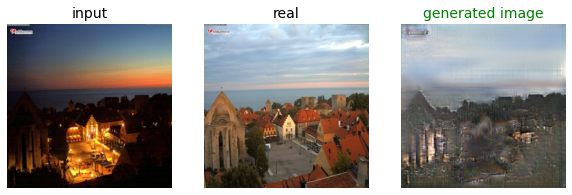

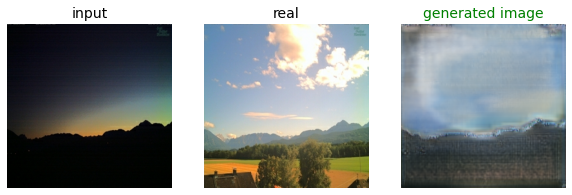

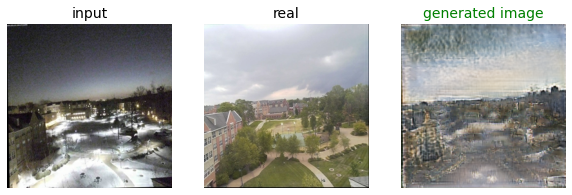

+-------------------------------------------+
|         EPOCH:  21/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 21    | 0:01:00.83 |    0.032 |     0.001 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  22/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 22    | 0:01:00.72 |    0.025 |     0.001 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  23/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 23    | 0:01:00.68 |    0.034 |     0.001 |
+-------+------------+----------+-----------+
+---------------------------------

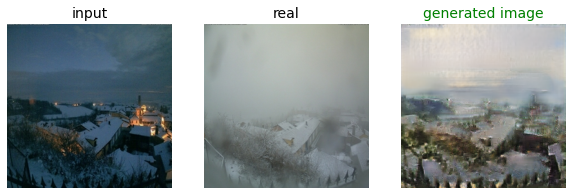

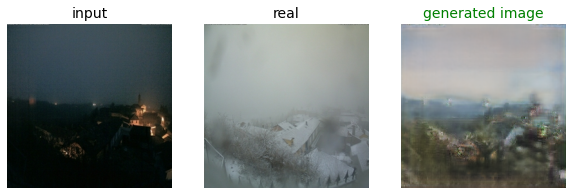

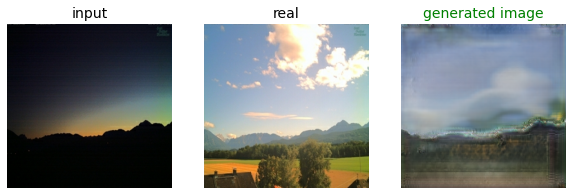

+-------------------------------------------+
|         EPOCH:  41/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 41    | 0:01:00.67 |    0.061 |     0.000 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  42/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 42    | 0:01:00.52 |    0.027 |     0.002 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  43/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 43    | 0:01:00.70 |    0.018 |     0.001 |
+-------+------------+----------+-----------+
+---------------------------------

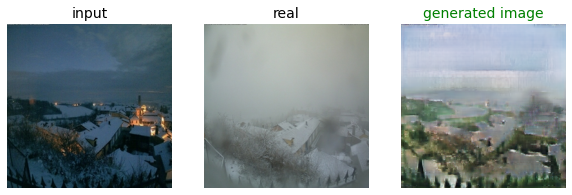

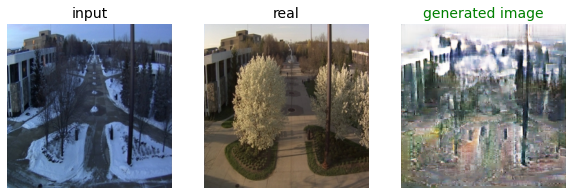

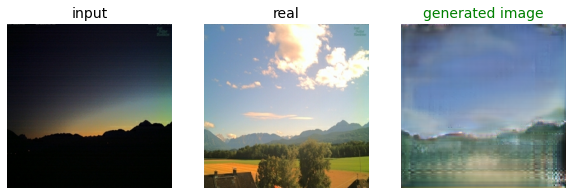

+-------------------------------------------+
|         EPOCH:  61/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 61    | 0:01:00.80 |    0.040 |     0.000 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  62/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 62    | 0:01:01.12 |    0.034 |     0.000 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  63/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 63    | 0:01:00.63 |    0.037 |     0.000 |
+-------+------------+----------+-----------+
+---------------------------------

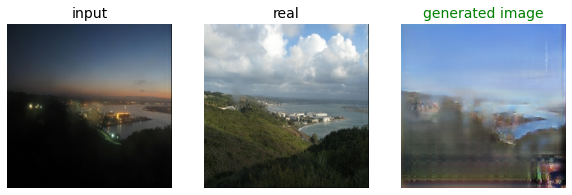

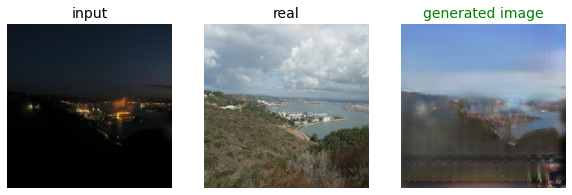

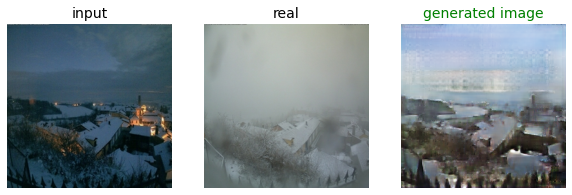

+-------------------------------------------+
|         EPOCH:  81/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 81    | 0:01:00.62 |    0.047 |     0.000 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  82/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 82    | 0:01:00.45 |    0.020 |     0.000 |
+-------+------------+----------+-----------+
+-------------------------------------------+
|         EPOCH:  83/100 no display         |
+-------+------------+----------+-----------+
| EPOCH |        ETA | GEN_LOSS | DISC_LOSS |
+-------+------------+----------+-----------+
| 83    | 0:01:00.44 |    0.038 |     0.000 |
+-------+------------+----------+-----------+
+---------------------------------

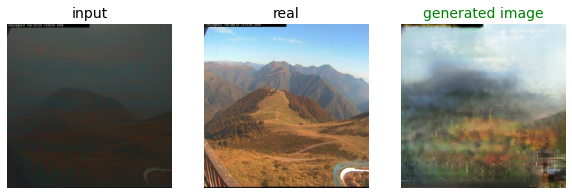

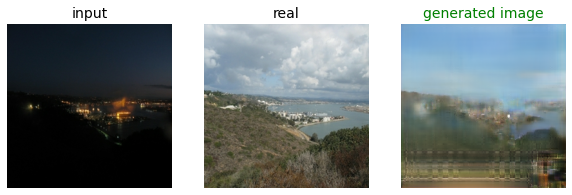

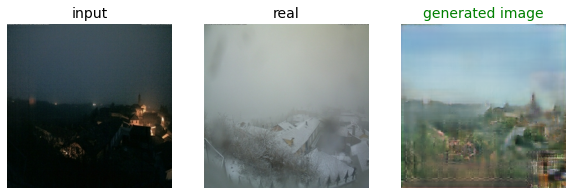

In [42]:
fit(train_ds, EPOCHS, valid_ds)

## Restore the latest checkpoint and test the network.

In [43]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Generating images from the `testing` set.

We are going to generate ``200`` images which are in the testing subset and display them.

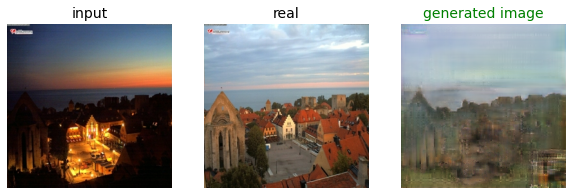

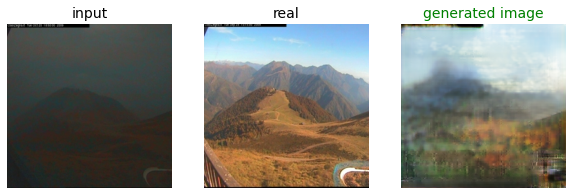

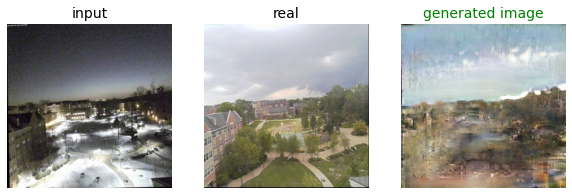

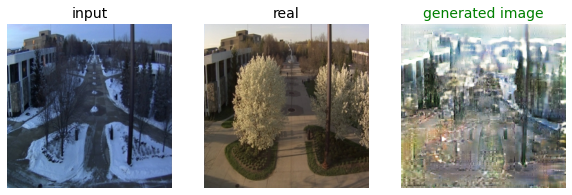

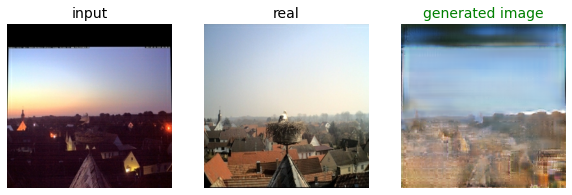

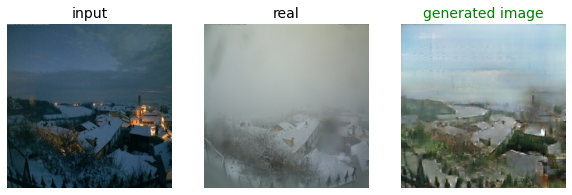

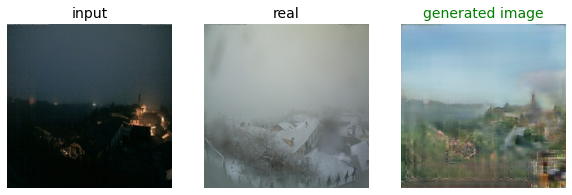

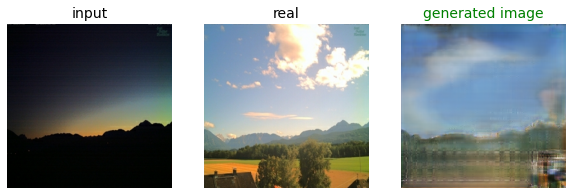

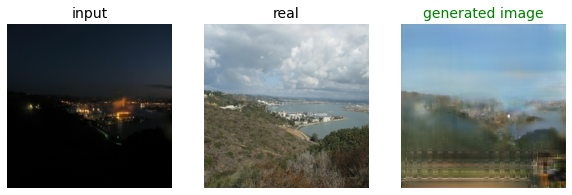

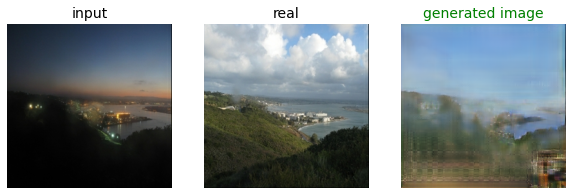

In [44]:
for inp, tar in train_ds.take(200):
  generate_images(generator_model, inp, tar)

### Ref:
* [this notebook](https://github.com/CrispenGari/Keras-API/blob/main/13_Unsupervised_L/02_Pix2Pix/01_Image_2_Image_Translation_With_Conditional_GAN.ipynb)

### Credits
* [this tensorflow tutorial](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb?authuser=2#scrollTo=4t4x69adQ5xb)